$$
\newcommand{\R}{\mathbb{R}}
\newcommand{\opt}{^{\star}}
$$

In [ ]:
# Import packages
import sys; sys.path.insert(0, "../../")
import numpy as np
import dualbounds as db
from dualbounds.generic import DualBounds

# Minimalist review of dual bounds

This section gives a minimal review of the dual bounds framework. A more complete review can be found in the first four pages of [Ji et al. (2023)](https://arxiv.org/abs/2310.08115). Users familiar with this content should skip this section. 


Given i.i.d. outcomes $Y_i \in \mathcal{Y}$, treatments $W_i \in \{0,1\}$ and pre-treatment covariates $X_i \in \mathcal{Y}$, dual bounds allow analysts to use machine learning to perform inference on partially identified estimands of the form

$$\theta = E[f(Y_i(0), Y_i(1), X_i)], $$

where $Y_i(1), Y_i(0) \in \mathcal{Y}$ denote potential outcomes. Such estimands are *partially identified* because we never observe the joint law of the potential outcomes, but the data still contains information on the law of $(Y(0), X)$ and $(Y(1), X)$ allowing us to *bound* $\theta$. (More generally, dual bounds can provde bounds on the solutions to generic optimization problems, but we defer discussion of this until later in the tutorial for simplicity).

Thus, to bound $\theta$, one must estimate the laws of $(Y(1), X)$ and $(Y(0), X)$, typically using sophisticated machine learning techniques. However, it is not clear if the resulting bounds on $\theta$ will be valid if the learned machine learning models are misspecified or inaccurate. For example, if one models $Y$ as having a linear relationship with $(X,W)$, but in truth $Y$ has a highly nonlinear relationship with $(X,W$), naive approaches could lead to inaccurate inference.

Dual bounds are designed to leverage the benefits of sophisticated ML models without sacrificing validity. This framework has three key properties:

1. Dual bounds can wrap on top of any ML model (e.g. generalized linear models, random forests, neural networks, etc).

2. In randomized experiments, dual bounds yield provably valid confidence intervals on $\theta$, even if the underlying ML model is arbitrarily misspecified or inaccurate. In observational studies, they have remarkably strong double robustness properties (see Section 3.4 of [Ji et al. (2023)](https://arxiv.org/abs/2310.08115)).

3. On the other hand, if the underlying ML model is highly accurate, dual bounds yield tight confidence bounds in a formal sense (see Section 3.2 of [Ji et al. (2023)](https://arxiv.org/abs/2310.08115)).

We refer the reader to the original paper for more details on how dual bounds work. In the next section, we show how to use dual bounds to perform inference on a variety of estimands 

# The ``DualBounds`` class

The ``DualBounds`` class is the main class in the package. Its usage is as follows. 

**Step 1**: initialize the ``DualBounds`` class, which takes as an input (i) the data, (ii) the definition of the function $f$ (which defines the estimand $\theta$), and (iii) a description of the outcome model to use as an input. The user can also input a vector of propensity scores if they are known; else they will be estimated from the data. 

For example, below, we show how to compute $E[\mathbb{I}(Y(1) > Y(0)]$, the probability that the treatment effect is positive.

In [2]:
# Generate synthetic data from a linear model
data = db.gen_data.gen_regression_data(n=900, p=30, sample_seed=123)

# Initialize dual bounds object
dbnd = DualBounds(
    f=lambda y0, y1, x: y0 < y1, # defines the estimand
    covariates=data['X'], # n x p covariate matrix
    treatment=data['W'], # n-length treatment vector
    outcome=data['y'], # n-length outcome vector
    propensities=data['pis'], # n-length propensity scores (optional)
    outcome_model='ridge', # description of model for Y | X, W
)


**Step 2**: after initialization, the ``compute_dual_bounds`` method fits the underlying outcome model and produces the final estimates and confidence bounds for the sharp partial identification bounds $\theta_L \le \theta \le \theta_U$. 

In [3]:
# Compute dual bounds and observe output
dbnd.fit(
    nfolds=5, # number of cross-fitting folds
    alpha=0.05, # nominal level,
    verbose=True # show progress bars
)
print(dbnd.results().to_markdown())

Cross-fitting the outcome model.


  0%|          | 0/5 [00:00<?, ?it/s]

Estimating optimal dual variables.


  0%|          | 0/900 [00:00<?, ?it/s]

|            |     Lower |     Upper |
|:-----------|----------:|----------:|
| Estimate   | 0.6832    | 0.934563  |
| SE         | 0.0210876 | 0.0125664 |
| Conf. Int. | 0.641869  | 0.959193  |


Note that there are two estimates---a lower and an upper estimate---because $\theta$ is not identified. One can also produce a more verbose output using the ``summary`` method:

In [4]:
dbnd.summary()

___________________Inference_____________________
               Lower     Upper
Estimate    0.683200  0.934563
SE          0.021088  0.012566
Conf. Int.  0.641869  0.959193

_________________Outcome model___________________
                      Model  No covariates
Out-of-sample R^2  0.931781       0.000000
RMSE               1.055246       4.040167
MAE                0.828872       3.228010

_________________Treatment model_________________
                            Model  No covariates
Out-of-sample R^2        0.001111       0.000000
Accuracy                 0.500000       0.516667
Likelihood (geom. mean)  0.500000       0.499721



Another example below bounds a different estimand, the positive treatment effect $E[\max(Y(1) - Y(0), 0)]$, using a different underlying ML model (a k-nearest neighbors regressor).

In [5]:
dbnd = DualBounds(
    f=lambda y0, y1, x: np.maximum(y1-y0,0), # new estimand
    covariates=data['X'],
    treatment=data['W'], 
    outcome=data['y'], 
    propensities=data['pis'], 
    outcome_model='knn', 
)
dbnd.fit()
print(dbnd.results().to_markdown())

Cross-fitting the outcome model.


  0%|          | 0/5 [00:00<?, ?it/s]

Estimating optimal dual variables.


  0%|          | 0/900 [00:00<?, ?it/s]

|            |    Lower |    Upper |
|:-----------|---------:|---------:|
| Estimate   | 2.92715  | 4.305    |
| SE         | 0.175792 | 0.151109 |
| Conf. Int. | 2.58261  | 4.60117  |


# Choosing the outcome model

Dual bounds wrap on top of an underlying model which estimates the conditional distributions of $Y(1) \mid X$ and $Y(0) \mid X$. There are three ways to specify the underlying model, listed below in order of increasing flexibility.

## Method 1: String identifiers

The easiest method is to use one of the string identifiers, such as ``'ridge', 'lasso', 'elasticnet', 'randomforest', 'knn'`` (see the API reference for a complete list):

In [6]:
dbnd = DualBounds(
    f=lambda y0, y1, x: np.maximum(y1-y0,0), # estimand
    covariates=data['X'], 
    treatment=data['W'], 
    outcome=data['y'],
    # use a random forest to predict E[Y | X]
    outcome_model='randomforest',
)

For binary data, these string identifiers assume a nonparametric model where $Y_i \sim \text{Bern}(\mu(X_i, W_i))$ and the conditional mean function $\mu$ is estimated via one of the models listed above (e.g., a random forest classifier).

For nonbinary data, these string identifiers use a semiparametric regression model:

$$Y_i = \mu(X_i, W_i) + \epsilon_i  $$

where the conditional mean function $\mu(\cdot, \cdot)$ is approximated using one of the models listed above (e.g., a random forest or k-nearest neighbors regressor). All methods automatically create interaction terms between the covariates and the treatment.

**Default 1: Homoskedasticity.** By default, these string identifiers estimate a homoskedastic model where the variance of $\epsilon_i$ does not depend on $X_i$. However, one can also specify a model to use to estimate the heteroskedasticity pattern, as shown below:

In [7]:
dbnd = DualBounds(
    f=lambda y0, y1, x: np.maximum(y1-y0,0), # estimand
    covariates=data['X'], 
    treatment=data['W'], 
    outcome=data['y'],
    # use a random forest to predict E[Y | X]
    outcome_model='randomforest', 
    # use lasso to predict Var(Y | X)
    heterosked_model='lasso',
)

That said, we emphasize that the default (homoskedastic) approach yields valid bounds even under arbitrary heteroskedasticity patterns.

**Default 2: Nonparametric residual estimates.** By default, these string identifiers estimate the law of $\epsilon_i$ using the empirical law of the training residuals (or, for ridge estimators, the leave-one-out residuals). However, it is possible to change this by changing the ``eps_dist`` parameter.

In [8]:
dbnd = DualBounds(
    f=lambda y0, y1, x: np.maximum(y1-y0,0), # estimand
    covariates=data['X'], 
    treatment=data['W'], 
    outcome=data['y'],
    propensities=data['pis'],
    # use a random forest to predict E[Y | X]
    outcome_model='randomforest',
    # assume a parametric model for the residuals
    # (the default is nonparametric)
    eps_dist='laplace', 
)

## Method 2: A ``dist_reg.DistReg`` class

Analysts can also specify the outcome model by passing in a model which inherits from ``dualbounds.dist_reg.DistReg``, including the ``CtsDistReg``, ``QuantileDistReg``, or and ``BinaryDistReg`` classes in the ``dualbounds.dist_reg`` submodule. One example is given below:

In [9]:
Y_model = db.dist_reg.CtsDistReg(
    model_type='elasticnet', 
    eps_dist='empirical',
    how_transform='interactions', # create interactions btwn X and W
    heterosked_model='lasso',
    heterosked_kwargs=dict(cv=3), # kwargs for model for Var(Y|X)
)
dbnd = DualBounds(
    outcome_model=Y_model, # use new model
    f=lambda y0, y1, x: np.maximum(y1-y0,0), # estimand
    covariates=data['X'], 
    treatment=data['W'], 
    outcome=data['y'],
    propensities=data['pis'],
)
dbnd.fit(alpha=0.05)
print(dbnd.results().to_markdown())

Cross-fitting the outcome model.


  0%|          | 0/5 [00:00<?, ?it/s]

Estimating optimal dual variables.


  0%|          | 0/900 [00:00<?, ?it/s]

|            |   Lower |     Upper |
|:-----------|--------:|----------:|
| Estimate   | 3.08487 | 3.29493   |
| SE         | 0.10184 | 0.0951055 |
| Conf. Int. | 2.88527 | 3.48134   |


One can also directly input ``sklearn`` or ``sklearn``-like classes. For example, below we show how to use the ``AdaBoostClassifier`` from sklearn for binary data.

In [10]:
import sklearn.ensemble as ensemble
Y_model = db.dist_reg.BinaryDistReg(
    model_type=ensemble.AdaBoostClassifier,
    algorithm='SAMME'
)
dbnd = DualBounds(
    outcome_model=Y_model, # use new model
    f=lambda y0, y1, x: y0 < y1, # estimand
    outcome=data['y'] > 0, # make the outcome binary
    # other data
    treatment=data['W'], 
    covariates=data['X'],
    propensities=data['pis'],
)
dbnd.fit(alpha=0.05)
print(dbnd.results().to_markdown())

Cross-fitting the outcome model.


  0%|          | 0/5 [00:00<?, ?it/s]

Estimating optimal dual variables.


  0%|          | 0/900 [00:00<?, ?it/s]

|            |     Lower |     Upper |
|:-----------|----------:|----------:|
| Estimate   | 0.294189  | 0.397205  |
| SE         | 0.0284652 | 0.0226536 |
| Conf. Int. | 0.238398  | 0.441606  |


Analysts can also create custom classes inheritting from ``dualbounds.dist_reg.DistReg``, allowing analysts to use (e.g.) custom conditional variance estimators---see the API reference for more details.

## Method 3: Input predicted conditional distributions

For maximum flexibility, one can also directly input predicted conditional distributions of $Y(1) \mid X$ and $Y(0) \mid X$, in the form of a list of batched scipy distributions whose shapes sum to the number of datapoints.

This is illustrated below, although for simplicity the inputs have nothing to do with the true distributions of $Y(1) \mid X$ and $Y(0) \mid X$. Note that in real applications, it is extremely important that the estimates of $Y(1) \mid X$ and $Y(0) \mid X$ must be computed using cross-fitting, otherwise the dual bounds may not be valid.

In [11]:
from scipy import stats
n = len(data['y']) # number of data-points

# Initialize object
dbnd = DualBounds(
    Y_model='lasso', # this will be ignored
    f=lambda y0, y1, x : y0 < y1, # estimand
    # data
    outcome=data['y'],
    treatment=data['W'], 
    covariates=data['X'],
    propensities=data['pis'],
)

# Either of the following input formats work
y0_dists = stats.norm(loc=np.zeros(n))
y1_dists = [
    stats.norm(loc=np.zeros(int(n/2)), scale=2), 
    stats.norm(loc=np.zeros(int(n/2)), scale=3)
]
# Compute dual bounds using y0_dists and y1_dists
dbnd.fit(
    y0_dists=y0_dists,
    y1_dists=y1_dists,
    suppress_warning=True,
)
print(dbnd.results().to_markdown())

Estimating optimal dual variables.


  0%|          | 0/900 [00:00<?, ?it/s]

|            |     Lower |     Upper |
|:-----------|----------:|----------:|
| Estimate   | 0.318794  | 1.2159    |
| SE         | 0.0391768 | 0.0261528 |
| Conf. Int. | 0.242008  | 1.26716   |


This syntax can be useful if in simulations one wants to compute an "oracle dual bound" which has perfect knowledge of the conditional distributions of $Y(0) \mid X$ and $Y(1) \mid X$, as illustrated below.

In [12]:
# Compute oracle dual bounds using the true conditional dists of Y0/Y1
dbnd.fit(
    y0_dists=data['y0_dists'],
    y1_dists=data['y1_dists'],
    suppress_warning=True,
)
print(dbnd.results().to_markdown())

Estimating optimal dual variables.


  0%|          | 0/900 [00:00<?, ?it/s]

|            |     Lower |     Upper |
|:-----------|----------:|----------:|
| Estimate   | 0.675722  | 0.929035  |
| SE         | 0.0208299 | 0.0126281 |
| Conf. Int. | 0.634896  | 0.953786  |


Note that the output of the oracle dual bounds is extremely similar to the output of the initial dual bounds in the third cell.

# Choosing the propensity scores

Dual bounds can also apply to observational data where the propensity scores must be estimated. In this case, analysts can specify the model used to estimate the propensity scores---the ``propensity_model``---with one of three methods. First, one can use a string identifier:

In [13]:
dbnd = DualBounds(
    propensity_model='ridge', # logistic ridge for prop. scores
    outcome_model='lasso',
    f=lambda y0, y1, x: y0 < y1, # estimand
    outcome=data['y'],
    treatment=data['W'], 
    covariates=data['X'],
)
dbnd.fit().summary()

Fitting propensity scores.


  0%|          | 0/5 [00:00<?, ?it/s]

Cross-fitting the outcome model.


  0%|          | 0/5 [00:00<?, ?it/s]

Estimating optimal dual variables.


  0%|          | 0/900 [00:00<?, ?it/s]

___________________Inference_____________________
               Lower     Upper
Estimate    0.692290  0.931634
SE          0.020940  0.013118
Conf. Int.  0.651249  0.957345

_________________Outcome model___________________
                      Model  No covariates
Out-of-sample R^2  0.931776       0.000000
RMSE               1.055278       4.040167
MAE                0.827924       3.228010

_________________Treatment model_________________
                            Model  No covariates
Out-of-sample R^2        0.007721       0.000000
Accuracy                 0.535556       0.516667
Likelihood (geom. mean)  0.501630       0.499721



Second, one can directly input an sklearn classifier.

In [14]:
dbnd = DualBounds(
    propensity_model=ensemble.AdaBoostClassifier(algorithm='SAMME'), 
    f=lambda y0, y1, x: y0 < y1, # estimand
    outcome=data['y'],
    treatment=data['W'], 
    covariates=data['X']
)
dbnd.fit().summary()

Fitting propensity scores.


  0%|          | 0/5 [00:00<?, ?it/s]

Cross-fitting the outcome model.


  0%|          | 0/5 [00:00<?, ?it/s]

Estimating optimal dual variables.


  0%|          | 0/900 [00:00<?, ?it/s]

___________________Inference_____________________
               Lower     Upper
Estimate    0.685896  0.933438
SE          0.021124  0.012638
Conf. Int.  0.644494  0.958209

_________________Outcome model___________________
                      Model  No covariates
Out-of-sample R^2  0.931781       0.000000
RMSE               1.055246       4.040167
MAE                0.828872       3.228010

_________________Treatment model_________________
                            Model  No covariates
Out-of-sample R^2       -0.014126       0.000000
Accuracy                 0.501111       0.516667
Likelihood (geom. mean)  0.496089       0.499721



Lastly, analysts can also directly estimate the vector propensity scores and input them, although analysts should ensure that they are correctly employing cross-fitting in this case to ensure validity.

# Model selection with the multiplier bootstrap (recommended)

In randomized experiments, the ``DualBounds`` object produces valid confidence intervals under arbitrary misspecification of the outcome model, meaning that the analyst can try many different outcome models to see which produces the tightest bounds. After fitting many outcome models and computing dual bounds based on each of them, the multiplier bootstrap provides a principled way to combine evidence across many different estimates while retaining rigorous coverage guarantees for the final confidence interval (i.e., accounting for multiplicity).

Below, we show how to do this in challenging setting with heteroskedasticity.

In [15]:
# Generate synthetic data from a linear model with heteroskedasticity
data = db.gen_data.gen_regression_data(
    n=900, # Num. datapoints
    p=30, # Num. covariates
    tauv=0.2,
    interactions=True, # ensures treatment effect is heterogenous
    heterosked='exp_linear', # Pattern of heteroskedasticity
    eps_dist='laplace',
    sample_seed=123, # random seed
)

First, we compute dual bounds based on several different choices of outcome model.

In [16]:
# Nominal level
alpha = 0.1
# List of dualbounds objects
db_objects = []
widths = []
Y_models = ['ridge', 'rf']
heterosked_models = ['none', 'lasso', 'rf']
model_names = []
for Y_model in Y_models:
    for heterosked_model in heterosked_models:
        print(f"Fitting outcome_model={Y_model}, heterosked_model={heterosked_model}.")
        gdb = DualBounds(
            # data
            outcome=data['y'],
            treatment=data['W'], 
            covariates=data['X'],
            propensities=data['pis'],
            # estimand
            f=lambda y0, y1, x: y0 < y1,
            # models
            outcome_model=Y_model,
            heterosked_model=heterosked_model,
            eps_dist='laplace',
        )
        gdb.fit(nfolds=3, alpha=alpha, verbose=False)
        db_objects.append(gdb)
        widths.append(gdb.cis[1] - gdb.cis[0])
        model_names.append(f'Y_model={Y_model}\nHeterosked={heterosked_model}')

Fitting outcome_model=ridge, heterosked_model=none.
Fitting outcome_model=ridge, heterosked_model=lasso.
Fitting outcome_model=ridge, heterosked_model=rf.
Fitting outcome_model=rf, heterosked_model=none.
Fitting outcome_model=rf, heterosked_model=lasso.
Fitting outcome_model=rf, heterosked_model=rf.


Second, we aggregate the bounds using the multiplier bootstrap.

In [17]:
bootstrap_output = db.bootstrap.dualbound_multiplier_bootstrap(
    db_objects, alpha=alpha
)
print(bootstrap_output.to_markdown())

|           |    Lower |    Upper |
|:----------|---------:|---------:|
| Estimate  | 0.68564  | 0.86214  |
| Conf. Int | 0.637019 | 0.897106 |


We can see that the bootstrap output width is nearly equal to the smallest width among all methods.

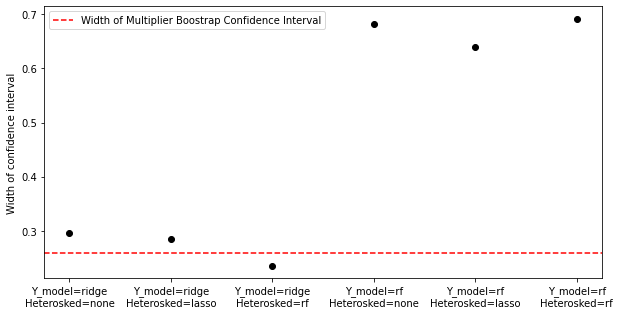

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
bootstrap_width = bootstrap_output.values[1, 1] 
bootstrap_width -= bootstrap_output.values[1, 0]
ax.scatter(model_names, widths, color='black')
ax.axhline(
    bootstrap_width, 
    label='Width of Multiplier Boostrap Confidence Interval', 
    color='red',
    linestyle='dashed',
)
ax.set(ylabel="Width of confidence interval")
ax.legend()
plt.show()

# Additional estimands

Dual bounds can apply beyond the settings described in the previous sections. 

## Variance of the CATE

Dual bounds can also be used to *lower-bound* the variance of the conditional average treatment effect $\theta = \text{Var}(E[Y(1) - Y(0) \mid X])$, as shown below.

In [19]:
vdb = db.varcate.VarCATEDualBounds(
    outcome=data['y'],
    treatment=data['W'], 
    covariates=data['X'],
    propensities=data['pis'],
    outcome_model='elasticnet',
)
vdb.fit()
print(vdb.results().to_markdown())

Cross-fitting the outcome model.


  0%|          | 0/5 [00:00<?, ?it/s]

|            |    Lower |   Upper |
|:-----------|---------:|--------:|
| Estimate   | 7.20519  |     nan |
| SE         | 0.528092 |     nan |
| Conf. Int. | 6.33655  |     nan |


## Variance of the ITE

Dual bounds can also be used to upper and lower bound the variance of the individual treatment effect $\theta = \text{Var}(Y(1) - Y(0))$, as shown below.

In [20]:
vdb = db.varite.VarITEDualBounds(
    outcome=data['y'],
    treatment=data['W'], 
    covariates=data['X'],
    propensities=data['pis'],
    outcome_model='elasticnet',
)
vdb.fit()
print(vdb.results().to_markdown())

Cross-fitting the outcome model.


  0%|          | 0/5 [00:00<?, ?it/s]

Estimating optimal dual variables.


  0%|          | 0/900 [00:00<?, ?it/s]

|            |    Lower |     Upper |
|:-----------|---------:|----------:|
| Estimate   | 8.74237  | 11.7923   |
| SE         | 0.575671 |  0.676127 |
| Conf. Int. | 7.61408  | 13.1174   |


## Generic extensions via the delta method

Using the delta method, dual bounds can also be used to upper and lower bound estimands of the form

$$\theta = h(E[f(Y(0), Y(1), X)], E[z_1(Y(1), X)], E[z_0(Y(0), X)]) $$

where $h$ is a continuous function that is nondecreasing in its first input, $f$ is a real-valued function, and $z_1$ and $z_0$ are potentially vector-valued functions. Using the ``dualbounds.delta.DeltaDualBounds`` class, one can directly input these functions to produce dual bounds:

In [21]:
delta_db = db.delta.DeltaDualBounds(
    # input arbitrary functions
    h=lambda fval, z1, z0: fval / z0 + z1[0] * z1[1],
    z1=lambda y1, x: np.array([y1, x[0]]),
    z0=lambda y0, x: y0**2,
    f=lambda y0, y1, x: np.maximum(y1, y0),
    # input data
    outcome=data['y'],
    treatment=data['W'], 
    covariates=data['X'],
    propensities=data['pis'],
)
delta_db.fit()
print(delta_db.results().to_markdown())

Cross-fitting the outcome model.


  0%|          | 0/5 [00:00<?, ?it/s]

Estimating optimal dual variables.


  0%|          | 0/900 [00:00<?, ?it/s]

|            |    Lower |    Upper |
|:-----------|---------:|---------:|
| Estimate   | 0.394742 | 0.403239 |
| SE         | 0.100678 | 0.101925 |
| Conf. Int. | 0.197417 | 0.603009 |


Indeed, the above code yields bounds on the estimand

$$\theta = \frac{E[(Y(1)-Y(0))_+]}{E[Y(0)^2]} + E[Y(1)] \cdot E[X_1].$$

## Lee Bounds under monotonicity

Lee bounds are a method to bound the average treatment effect in the face of post-treatment nonrandom sample selection, named in honor of  [Lee (2009)](https://www.jstor.org/stable/40247633). Precisely, we assume we observe the following data:

- Pre-treatment covariates $X_i \in \mathcal{X}$

- A binary treatment $W_i \in \{0,1\}$
 
- A post-treatment selection indicator $S_i \in \{0,1\}$.
 
- An outcome $Y_i \in \mathbb{R}$.

Note that both $Y_i$ and $S_i$ have potential outcomes $(Y_i(0), Y_i(1))$ and $(S_i(0), S_i(1))$ since both potentially depend on the treatment.

A classic example is a setting where $W_i$ denotes enrollment in a job training program, $S_i$ denotes whether a subject entered the labor market, and the outcome $Y_i$ denotes wages. A natural estimand in these settings is the average treatment effect for subjects who would have entered the labor market no matter their treatment status; e.g., 

$$E[Y(1) - Y(0) \mid S(1) = S(0) = 1]. $$

Dual bounds can be used to bound this partially identified estimand under the **monotonicity** assumption that $S(1) \ge S(0)$ a.s., as shown below.

In [22]:
# create data
lee_data = db.gen_data.gen_lee_bound_data(n=900, p=30, sample_seed=123)

# fit lee bounds
ldb = db.lee.LeeDualBounds(
    # data
    selections=lee_data['S'], 
    covariates=lee_data['X'], 
    treatment=lee_data['W'],
    propensities=lee_data['pis'], 
    outcome=lee_data['y'],
    # Model specifications
    outcome_model='ridge',
    selection_model='monotone_logistic',
)
ldb.fit().summary()

Cross-fitting the selection model.


  0%|          | 0/5 [00:00<?, ?it/s]

Cross-fitting the outcome model.


  0%|          | 0/5 [00:00<?, ?it/s]

Estimating optimal dual variables.


  0%|          | 0/900 [00:00<?, ?it/s]

___________________Inference_____________________
               Lower     Upper
Estimate    2.220620  3.155182
SE          0.191205  0.193274
Conf. Int.  1.845866  3.533992

________________Selection model__________________
                            Model  No covariates
Out-of-sample R^2        0.172740       0.000000
Accuracy                 0.703333       0.594444
Likelihood (geom. mean)  0.557705       0.508488

_________________Outcome model___________________
                      Model  No covariates
Out-of-sample R^2  0.919644       0.000000
RMSE               1.057244       3.729639
MAE                0.846142       2.954590

________________Treatment model__________________
                            Model  No covariates
Out-of-sample R^2        0.001111       0.000000
Accuracy                 0.500000       0.516667
Likelihood (geom. mean)  0.500000       0.499721



It is also possible to bound this estimand without the monotonicity assumption using the generic ``DualBounds`` class, although we caution that without the monotonicity assumption, the bounds might be too wide to be useful. Please see [Ji et al. (2023)](https://arxiv.org/pdf/2310.08115.pdf), Section 2.5 for details.